# Notes

In [ ]:
# ref: https://huggingface.co/transformers/v3.3.1/pretrained_models.html

# Import modules

In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

import sys
sys.path.append('../')
from src.config import *
from src.helper_visualization import *
from src.helper_pred import *

from datasets import Dataset
from sklearn.metrics import accuracy_score, classification_report

# Load Train Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103911 entries, 0 to 103910
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Request ID        103911 non-null  int64 
 1   Title             103911 non-null  object
 2   Product Name      103911 non-null  object
 3   Length            103911 non-null  int64 
 4   Language          103911 non-null  object
 5   Title_Processed   103911 non-null  object
 6   Title_Translated  103911 non-null  object
 7   Title_Enhanced    103911 non-null  object
 8   Tags              103911 non-null  object
dtypes: int64(2), object(7)
memory usage: 7.1+ MB
None


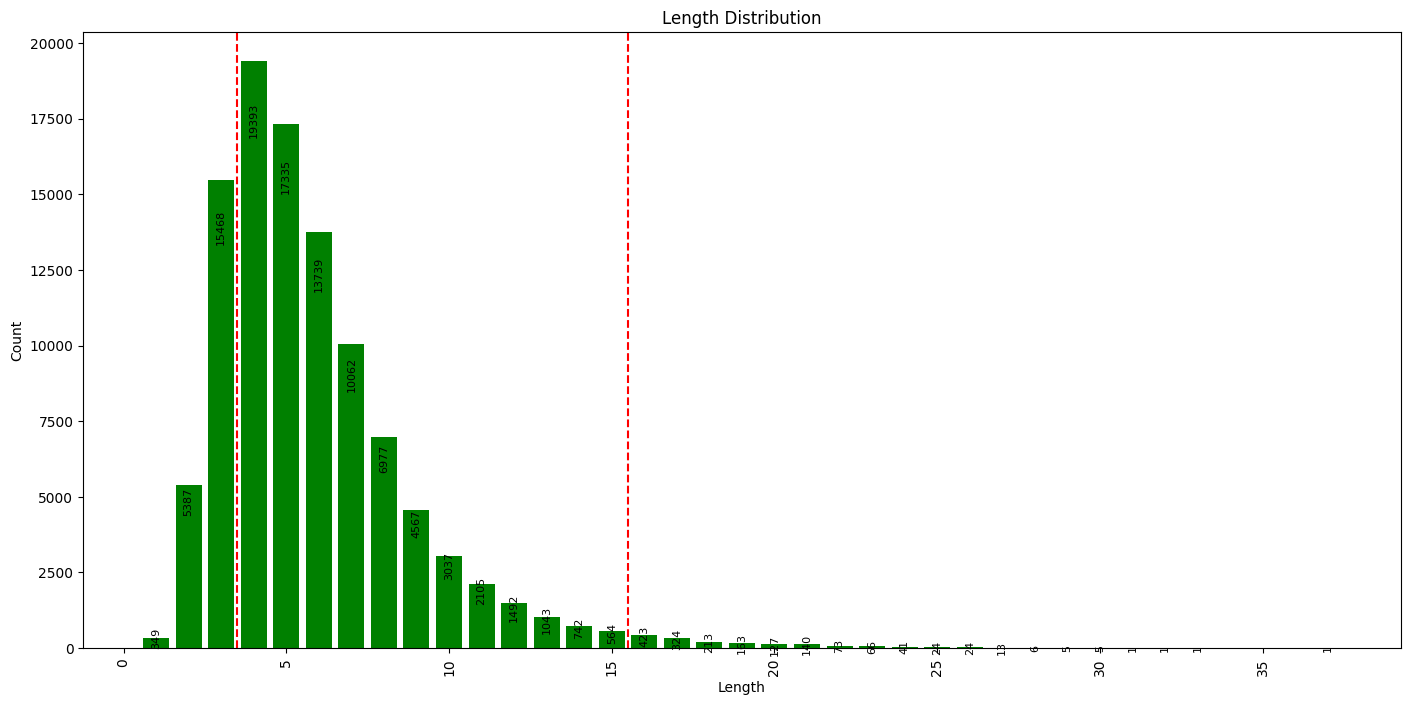

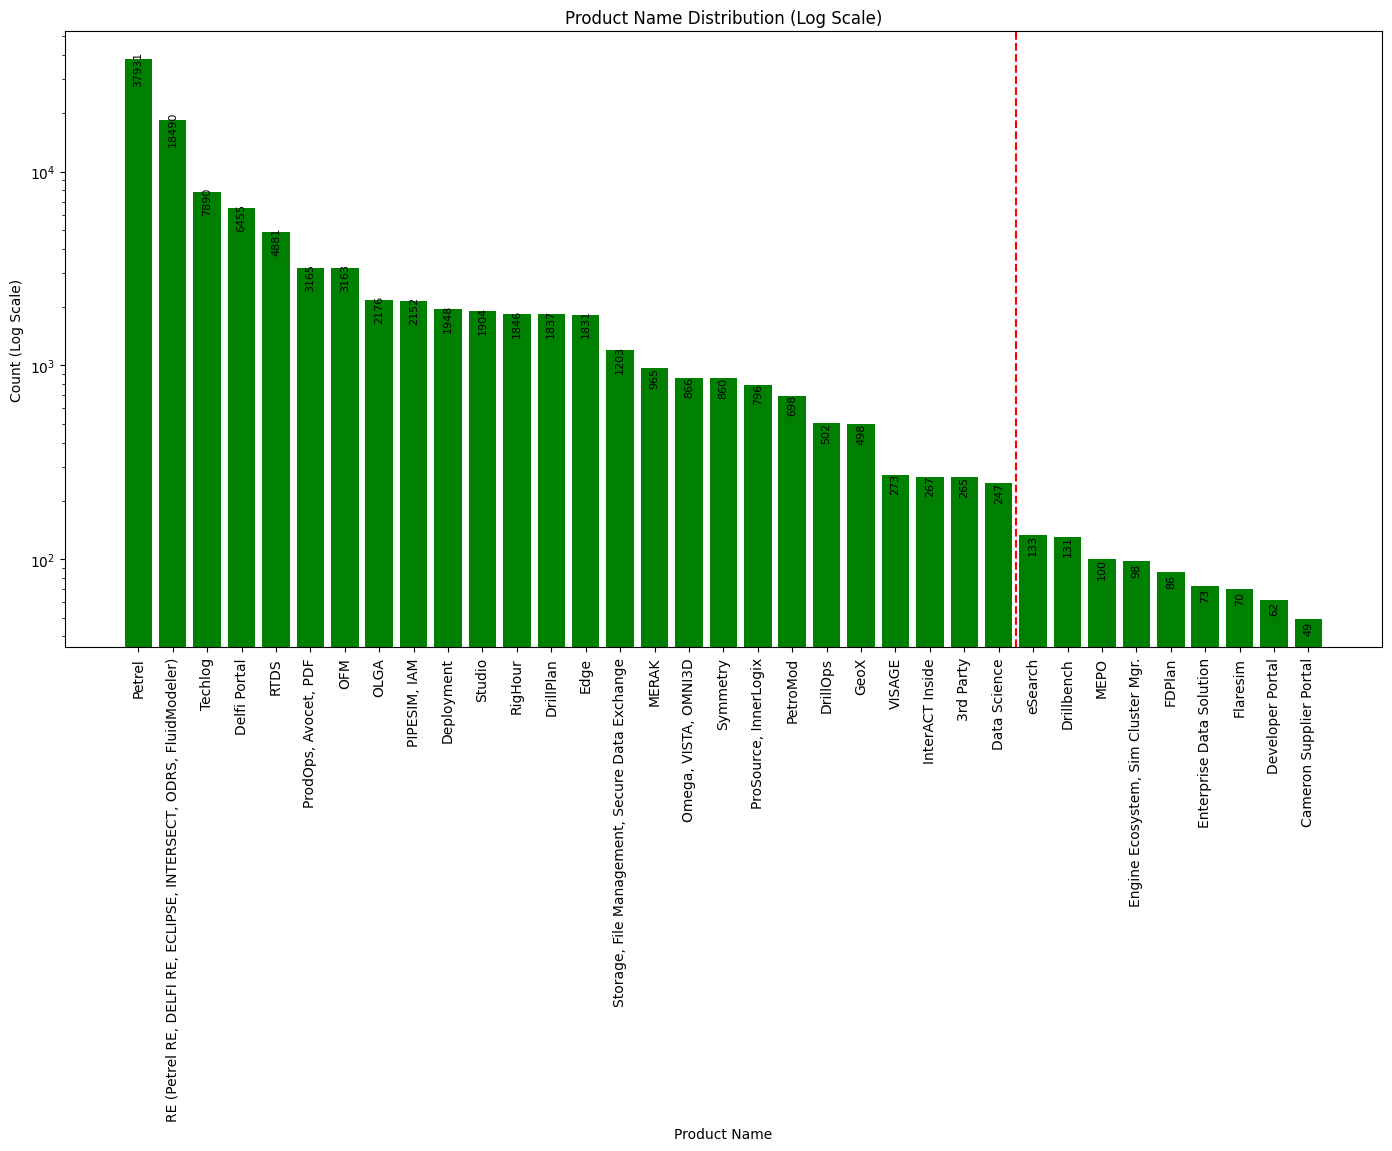

In [2]:
excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'
df_train = pd.read_excel(excel_file_train)

print(df_train.info())
hist_by_labels(df_train, 'Length', log=False, left=3.5, right=15.5)
hist_by_labels(df_train, 'Product Name', log=True, right=25.5)

# Data Processing

In [3]:
# Define global variables
TITLE_WORDS_MIN = 3
TITLE_WORDS_MAX = 20
LONGTAIL_CUTOFF = 200

TEXT_COL = 'Title_Enhanced'
TARGET_COL = 'Product Name'

PRODUCT_SIZE_MAX_TRAIN = 2000
PRODUCT_SIZE_MAX_TEST = 220
MAX_FEATURES = 20000

from sklearn.base import BaseEstimator, TransformerMixin

# create a scikit-learn transformer to remove the title with less than 3 words or more than 20 words
class TitleLengthFilter(BaseEstimator, TransformerMixin):
    def __init__(self, min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX):
        self.min_words = min_words
        self.max_words = max_words
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        df = df[df['Length'] >= self.min_words]
        df = df[df['Length'] <= self.max_words]
        df = df.reset_index(drop=True)
        return df

# create a scikit-learn transformer to combine the products which have less than 200 samples into one product
class LongTailCombiner(BaseEstimator, TransformerMixin):
    def __init__(self, min_samples=200, target_col=TARGET_COL):
        self.min_samples = min_samples
        self.target_col = target_col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        counts = df[self.target_col].value_counts()
        long_tails = counts.index[counts < self.min_samples]
        mask = df[self.target_col].isin(long_tails)
        df.loc[mask, self.target_col]='Long Tail'
        return df

# create a scikit-learn transformer to cap the number of samples for each product
class SampleCapper(BaseEstimator, TransformerMixin):
    def __init__(self, max_samples=200, target_col=TARGET_COL):
        self.max_samples = max_samples
        self.target_col = target_col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        counts = df[self.target_col].value_counts()
        over_sampled = counts.index[counts > self.max_samples]
        # mask = df[self.target_col].isin(over_sampled)
        # df = df.drop(df[mask].sample(frac=1-self.max_samples/len(df)).index)
        for item in over_sampled:
            size = len(df[df[self.target_col]==item])
            df = df.drop(df[df[self.target_col]==item].sample(frac=1-self.max_samples/size).index)
        return df
# create a scikit-learn transformer to lower case the text
class TextLower(BaseEstimator, TransformerMixin):
    def __init__(self, text_col=TEXT_COL):
        self.text_col = text_col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        df[self.text_col] = df[self.text_col].str.lower()
        return df

# create a scikit-learn pipeline to remove the title with less than 3 words or more than 20 words
from sklearn.pipeline import Pipeline

pipleline_data_prep_train = Pipeline([
    ('title_length_filter', TitleLengthFilter(min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX)),
    ('long_tail_product_combiner', LongTailCombiner(min_samples=LONGTAIL_CUTOFF, target_col=TARGET_COL)),
    ('sample_capper', SampleCapper(max_samples=PRODUCT_SIZE_MAX_TRAIN, target_col=TARGET_COL)),
    ('text_lower', TextLower(text_col=TEXT_COL))
])

pipleline_data_prep_test = Pipeline([
    ('title_length_filter', TitleLengthFilter(min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX)),
    ('long_tail_product_combiner', LongTailCombiner(min_samples=LONGTAIL_CUTOFF*12//100, target_col=TARGET_COL)),
    ('sample_capper', SampleCapper(max_samples=PRODUCT_SIZE_MAX_TEST, target_col=TARGET_COL)),
    ('text_lower', TextLower(text_col=TEXT_COL))
])
display(pipleline_data_prep_train)
display(pipleline_data_prep_test)

Pipeline(steps=[('title_length_filter', TitleLengthFilter()),
                ('long_tail_product_combiner', LongTailCombiner()),
                ('sample_capper', SampleCapper(max_samples=2000)),
                ('text_lower', TextLower())])

Pipeline(steps=[('title_length_filter', TitleLengthFilter()),
                ('long_tail_product_combiner',
                 LongTailCombiner(min_samples=24)),
                ('sample_capper', SampleCapper(max_samples=220)),
                ('text_lower', TextLower())])

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode the target labels
le = LabelEncoder()

# Train data
df_train_processed = pipleline_data_prep_train.fit_transform(df_train)
df_train_processed = df_train_processed.reset_index(drop=True)
df_train_processed = df_train_processed.rename(columns={TEXT_COL: 'text'})
df_train_processed['label'] = le.fit_transform(df_train_processed[TARGET_COL])
display(df_train_processed.info())
display(df_train_processed.head())

# Split train data into train and eval
train_data = df_train_processed[['text', 'label']]
train_data, eval_data = train_test_split(train_data, test_size=0.15, stratify=train_data['label'], random_state=42)
hg_train_data = Dataset.from_pandas(train_data)
hg_eval_data = Dataset.from_pandas(eval_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34736 entries, 0 to 34735
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        34736 non-null  int64 
 1   Title             34736 non-null  object
 2   Product Name      34736 non-null  object
 3   Length            34736 non-null  int64 
 4   Language          34736 non-null  object
 5   Title_Processed   34736 non-null  object
 6   Title_Translated  34736 non-null  object
 7   text              34736 non-null  object
 8   Tags              34736 non-null  object
 9   label             34736 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 2.7+ MB


None

,Request ID,Title,Product Name,Length,Language,Title_Processed,Title_Translated,text,Tags,label
0,765063,[Ext] Can Not Run Simulators in Petrel - Reope...,"RE (Petrel RE, DELFI RE, ECLIPSE, INTERSECT, O...",3,en,Ext Can Not Run Simulators in Petrel Reopen ti...,Ext Can Not Run Simulators in PetrelREopen ticket,run simulators petrelreopen,simulator petrelreopen,19
1,2308663,Agora | ECP | Ecuador : On/Off Notifications ...,Edge,7,en,Agora ECP Ecuador : On Off Notifications are n...,Agora ECP Ecuador : On Off Notifications are n...,agora electronic control panel ( ecp ) notific...,ecp notification agora panel electronic contro...,6
2,244155,[Ext] Neptune Energy - Drillbench,Long Tail,3,en,Ext Neptune Energy Drillbench,Ext Neptune Energy Drillbench,neptune energy drillbench,energy drillbench neptune,9
3,976443,Well 32 gas injection total is different,"ProdOps, Avocet, PDF",5,en,Well gas injection total is different,Well gas injection total is different,well gas injection total different,gas different total well injection,18
4,928553,How to set the Porosity-Depth trends for the l...,PetroMod,11,en,How to set the Porosity Depth trends for the l...,How to set the Porosity Depth trends for the l...,set porosity depth trends lithologies model de...,model depth lithology deal trend porosity inco...,16


# Hugging Face Transformer

In [5]:
# import Hugging Face transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import evaluate

## Training

In [16]:
# ref: https://huggingface.co/transformers/v3.3.1/pretrained_models.html
BERT_MODEL = 'bert-base-uncased' # 12-layer, 768-hidden, 12-heads, 110M parameters. Trained on lower-cased English text.
# BERT_MODEL = 'distilbert-base-uncased' # 6-layer, 768-hidden, 12-heads, 66M parameters. Trained on lower-cased English text.

# train_data = train_data.sample(frac=1.0, random_state=42).reset_index(drop=True)
# eval_data = eval_data.sample(frac=1.0, random_state=42).reset_index(drop=True)

n_classes = len(train_data.label.unique())
print(f'There are \033[94m{n_classes}\033[0m classes in the training data.')

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)

def tokenize(batch):
    return tokenizer(batch['text'], 
                    max_length=TITLE_WORDS_MAX,
                    padding='max_length', 
                    truncation=True)

hg_train_data_tokenized = hg_train_data.map(tokenize)
hg_eval_data_tokenized = hg_eval_data.map(tokenize)

model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=n_classes)

training_args = TrainingArguments(
    num_train_epochs=25,             # total number of training epochs
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_strategy='epoch',        # log every epoch
    logging_steps=100,               # log every 100 steps
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    learning_rate=5e-6,              # learning rate
    seed=42,                         # seed for reproducibility
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric = evaluate.load('accuracy')
    accuracy = metric.compute(predictions=predictions, references=labels)
    return accuracy

trainer = Trainer(
    model=model,                            # the instantiated 🤗 Transformers model to be trained
    args=training_args,                     # training arguments, defined above
    train_dataset=hg_train_data_tokenized,  # training dataset
    eval_dataset=hg_eval_data_tokenized,    # evaluation dataset
    compute_metrics=compute_metrics,        # the callback that computes metrics of interest
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

plot_transformer_training_history(trainer)
trainer.evaluate()

There are 27 classes in the training data.


Map:   0%|          | 0/29525 [00:00<?, ? examples/s]

Map:   0%|          | 0/5211 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/46150 [00:00<?, ?it/s]

## Evaluate on test data

In [15]:
# Load test data
excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'
df_test = pd.read_excel(excel_file_test)
df_test_processed = pipleline_data_prep_test.fit_transform(df_test)
df_test_processed = df_test_processed.reset_index(drop=True)
df_test_processed = df_test_processed.rename(columns={TEXT_COL: 'text'})
df_test_processed['label'] = le.transform(df_test_processed[TARGET_COL])
display(df_test_processed.info())
display(df_test_processed.head())

# evaluate on test data
test_data = df_test_processed[['text', 'label']]
hg_test_data = Dataset.from_pandas(test_data)
hg_test_data_tokenized = hg_test_data.map(tokenize)

y_actual = hg_test_data_tokenized['label']
y_pred = trainer.predict(hg_test_data_tokenized)
y_pred = np.argmax(y_pred.predictions, axis=-1)

accuracy = accuracy_score(y_actual, y_pred)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_actual, y_pred, digits=3, target_names=le.classes_)
print(report)

# plot_confusion_matrix(y_actual, y_pred)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3831 entries, 0 to 3830
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        3831 non-null   int64 
 1   Title             3831 non-null   object
 2   Product Name      3831 non-null   object
 3   Length            3831 non-null   int64 
 4   Language          3831 non-null   object
 5   Title_Processed   3831 non-null   object
 6   Title_Translated  3831 non-null   object
 7   text              3831 non-null   object
 8   Tags              3831 non-null   object
 9   label             3831 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 299.4+ KB


None

,Request ID,Title,Product Name,Length,Language,Title_Processed,Title_Translated,text,Tags,label
0,1588503,[Ext] ProSource Web user access,"ProSource, InnerLogix",4,en,Ext ProSource Web user access,Ext ProSource Web user access,prosource web user access,web prosource user access,17
1,1468429,Adding Separator [Phase Split Node] in OLGA Model,OLGA,10,en,Adding Separator Phase Split Node in OLGA Model,Adding Separator Phase Split Node in OLGA Model,adding separator phase split node oil gas simu...,gas model simulator olga node phase separator ...,12
2,1652655,Ralph Coffman : DrillOps_Amoca-11_Data Verific...,RTDS,5,en,Ralph Coffman : DrillOps Data Verification,Ralph Coffman : DrillOps Data Verification,ralph coffman drillops data verification,drillops coffman ralph verification data,20
3,1445309,Agora: Multiple Controllers for Lilian Rankins...,Edge,5,en,Agora: Multiple Controllers for Lilian Rankins,Agora: Multiple Controllers for Lilian Rankins,agora multiple controllers lilian rankins,lilian agora multiple rankin controller,6
4,1521197,[Ext] Forecast line couldn't display properly ...,OFM,8,en,Ext Forecast line couldn t display properly in...,Ext Forecast line couldn t display properly in...,forecast line display properly oil field manag...,forecast properly ofm management field line oi...,11


Map:   0%|          | 0/3831 [00:00<?, ? examples/s]

  0%|          | 0/240 [00:00<?, ?it/s]

Accuracy: 0.6197
                                                                  precision    recall  f1-score   support

                                                       3rd Party      0.000     0.000     0.000        29
                                                    Data Science      0.000     0.000     0.000        27
                                                    Delfi Portal      0.370     0.682     0.480       220
                                                      Deployment      0.466     0.590     0.521       210
                                                        DrillOps      0.800     0.314     0.451        51
                                                       DrillPlan      0.481     0.643     0.551       199
                                                            Edge      0.969     0.939     0.954       198
                                                            GeoX      0.875     0.840     0.857        50
                            

/Users/haitao/.pyenv/versions/3.11.6/envs/HF/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haitao/.pyenv/versions/3.11.6/envs/HF/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/haitao/.pyenv/versions/3.11.6/envs/HF/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

# Word2Vec

In [ ]:
from gensim.models import Word2Vec
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import optuna

# Load the pre-trained Word2Vec model
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')

# train the word2vec_model using additional X_train data
# word2vec_model.build_vocab(X_train, update=True)
word2vec_model.train(X_train, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)

# Define a function to encode the text using Word2Vec
def encode_text(text):
    words = text.split()
    vectors = []
    for word in words:
        if word in word2vec_model:
            vector = word2vec_model[word]
            vectors.append(vector)
    if len(vectors) == 0:
        return np.zeros(dim) # Return a vector of zeros if no words are found
    else:
        return np.mean(vectors, axis=0) # Return the mean of the word vectors

# Vectorize the training and testing data using Word2Vec
X_train_word2vec = [encode_text(text) for text in X_train]
X_test_word2vec = [encode_text(text) for text in X_test]


# Clean up the study if it exists
study_name = 'sgd_classifier_word2vec'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_word2vec, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)


In [ ]:

# Vectorize the training and testing data using Word2Vec
X_train_word2vec = [encode_text(text) for text in X_train]
X_test_word2vec = [encode_text(text) for text in X_test]


# Clean up the study if it exists
study_name = 'sgd_classifier_word2vec'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_word2vec, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)


In [ ]:
import gensim
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Load the pre-trained Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format(f'{MODEL_FOLDER_PATH}/word2vec/GoogleNews-vectors-negative300.bin', binary=True, limit=200000)


In [ ]:
# Load the pre-trained GloVe embeddings
embeddings_index = {}
dim = 300

with open(f'{MODEL_FOLDER_PATH}/glove/glove.6B.{dim}d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Define a function to encode the text using GloVe
def encode_text(text):
    words = text.split()
    vectors = []
    for word in words:
        if word in embeddings_index:
            vector = embeddings_index[word]
            vectors.append(vector)
    if len(vectors) == 0:
        return np.zeros(dim) # Return a vector of zeros if no words are found
    else:
        return np.mean(vectors, axis=0) # Return the mean of the word vectors

# Vectorize the training and testing data using GloVe
X_train_glove = [encode_text(text) for text in X_train]
X_test_glove = [encode_text(text) for text in X_test]

# Tensorflow

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_core as keras
import keras_nlp

print('Tensorflow version:', tf.__version__)
print('KerasNLP version:', keras_nlp.__version__)

In [ ]:
BATCH_SIZE = 32
NUM_TRAIN_SAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = NUM_TRAIN_SAMPLES * TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 3
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
from sklearn.model_selection import train_test_split

X = X_train
y = y_train

# encode the target
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)


In [ ]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"
NUM_CLASSES = len(df_train['Product Name'].unique())

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset, sequence_length=160, name="preprocessor_4_tweets")

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset, preprocessor = preprocessor, num_classes=NUM_CLASSES)

classifier.summary()

In [ ]:
# Compile the model
classifier.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-5),
    metrics=['accuracy'])

# Fit the model.
history = classifier.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
    )

In [ ]:
# plot the training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test data
y_pred_tf = classifier.predict(X_test)
y_pred_tf = np.argmax(y_pred_tf, axis=1)

# Decode the predictions
y_pred_tf = label_encoder.inverse_transform(y_pred_tf)

# Evaluate the model on the test data

accuracy = accuracy_score(y_test, y_pred_tf)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_tf, digits=3))

plot_confusion_matrix(y_test, y_pred_tf, title='Confusion matrix')